In [1]:
import pandas as pd
import numpy as np
from typing import Literal
import matplotlib.pyplot as plt
from numpy import array, ndarray, std, argsort
from pandas import read_csv, DataFrame, Series
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_horizontal_bar_chart, plot_bar_chart, read_train_test_from_files, plot_multibar_chart, evaluate_approach, HEIGHT, plot_evaluation_results, plot_multiline_chart
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


# Load split dataset

In [2]:
target = "CovidPos"
file_tag = "modeling/pos_covid_evaluation_RF"
eval_metric = "accuracy"

train: DataFrame = read_csv("datasets/class_pos_covid_train.csv", index_col="Unnamed: 0", na_values=None)
test: DataFrame = read_csv("datasets/class_pos_covid_test.csv", index_col="Unnamed: 0", na_values=None)

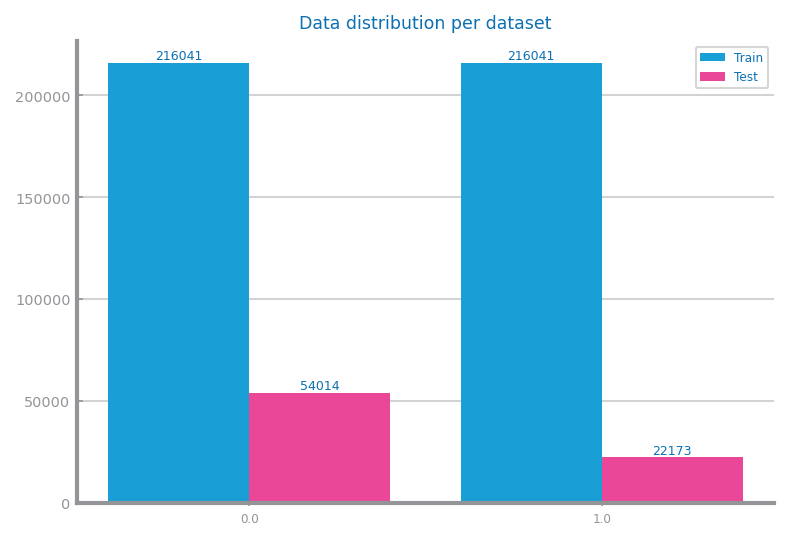

In [3]:
positive: int = 1
negative: int = 0
values: dict[str, list[int]] = {}

values["Train"] = [
    len(train[train[target] == negative]),
    len(train[train[target] == positive]),
]
values["Test"] = [
    len(test[test[target] == negative]),
    len(test[test[target] == positive]),
]

labels: list = list(train[target].unique())
labels.sort()

plt.figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
plt.show()

# Study

In [4]:
trnX = train.copy(deep=True)
trnY = trnX[target]
trnX = trnX.drop(target, axis=1)

tstX = test.copy(deep=True)
tstY = tstX[target]
tstX = tstX.drop(target, axis=1)
vars = trnX.columns.to_list()

In [5]:
def random_forests_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[RandomForestClassifier | None, dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    max_features: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: RandomForestClassifier | None = None
    best_params: dict = {"name": "RF", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}

    cols: int = len(max_depths)
    _, axs = plt.subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for f in max_features:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = RandomForestClassifier(
                    n_estimators=n, max_depth=d, max_features=f
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, f, n)
                    best_model = clf
                # print(f'RF d={d} f={f} n={n}')
            values[f] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"Random Forests with max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'RF best for {best_params["params"][2]} trees (d={best_params["params"][0]} and f={best_params["params"][1]})'
    )
    return best_model, best_params

## Default Hyperparams

RF best for 1000 trees (d=7 and f=0.1)


<Figure size 600x450 with 0 Axes>

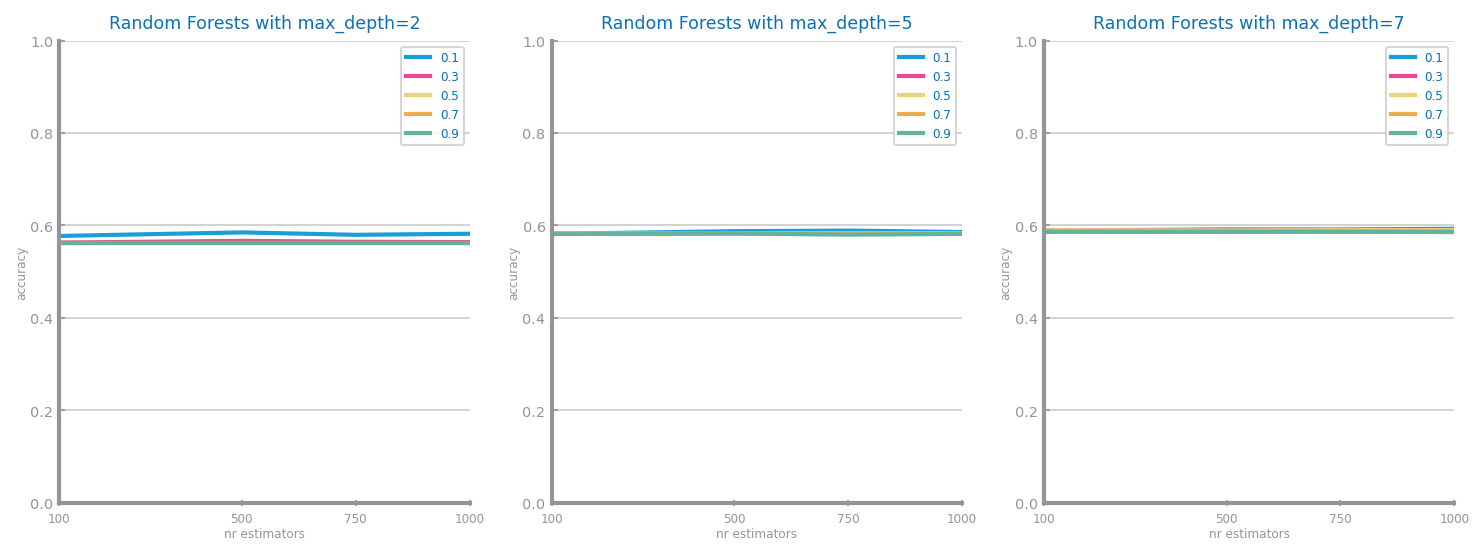

In [6]:
eval_metric = "accuracy"

plt.figure()
best_model_acc_1, params_acc_1 = random_forests_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
)
plt.savefig(f"images/{file_tag}_{eval_metric}_study.png")
plt.show()

# Performance Analysis

chosen recall because optimizing with accuracy vs recall doesnt change much, and since this is medical predictions is best to maximize recall score

<Figure size 600x450 with 0 Axes>

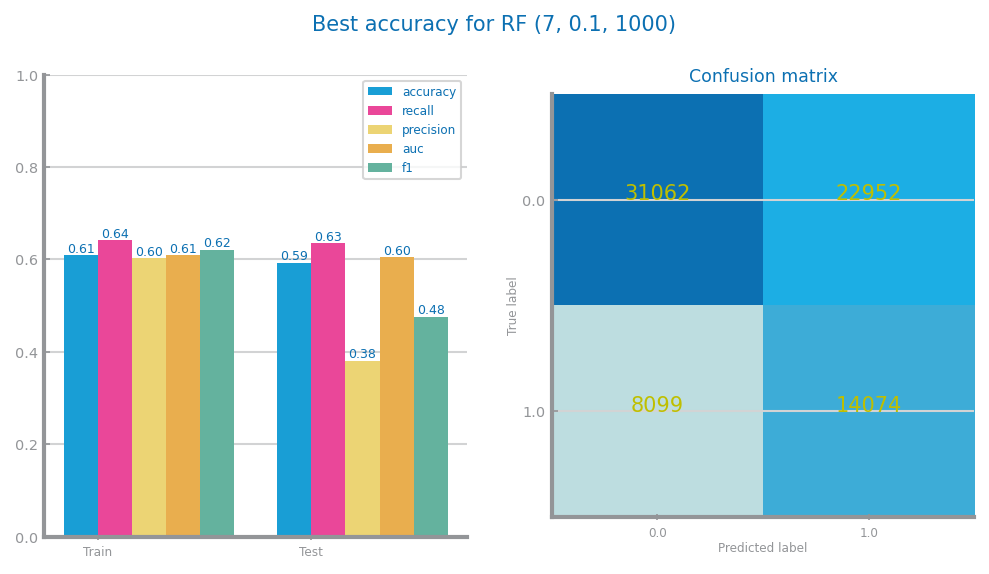

In [7]:
from dslabs_functions import plot_evaluation_results

best_model = best_model_acc_1
best_params = params_acc_1

prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
plt.figure()
plot_evaluation_results(best_params, trnY, prd_trn, tstY, prd_tst, labels)
plt.savefig(f'images/{file_tag}_{best_params["name"]}_best_{best_params["metric"]}_eval.png')
plt.show()

1. AgeCategory (0.3240406220294239)
2. PhysicalHealthDays (0.07738643030089949)
3. PneumoVaxEver (0.06397254196233013)
4. HIVTesting (0.056401193863379405)
5. BMI (0.05393553277402928)
6. FluVaxLast12 (0.048483839054357054)
7. WeightInKilograms (0.0480069438967973)
8. RemovedTeeth (0.04155440470750122)
9. SmokerStatus (0.030141316228569286)
10. MentalHealthDays (0.02908353424879891)
11. TetanusLast10Tdap (0.023475725744147715)
12. HadAsthma (0.02094642355294024)
13. SleepHours (0.018568138688552605)
14. ECigaretteUsage (0.01711280564556819)
15. HighRiskLastYear (0.0160282977482769)
16. LastCheckupTime (0.012369451118357567)
17. RaceEthnicityCategory (0.011557134332884373)
18. State (0.011016732514514207)
19. HadDepressiveDisorder (0.010707117084002309)
20. DifficultyWalking (0.010508073618912359)
21. AlcoholDrinkers (0.010374601371249174)
22. HadArthritis (0.010132880068766548)
23. Sex (0.009886069805938574)
24. ChestScan (0.00739763545968561)
25. HeightInMeters (0.006419053079865294)


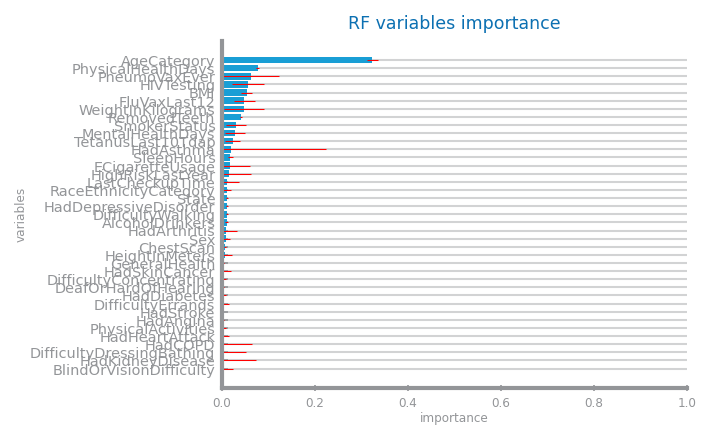

In [8]:
stdevs: list[float] = list(
    std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
)
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

plt.figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="RF variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
plt.savefig(f"images/{file_tag}_{eval_metric}_vars_ranking.png")

# Overfitting Study

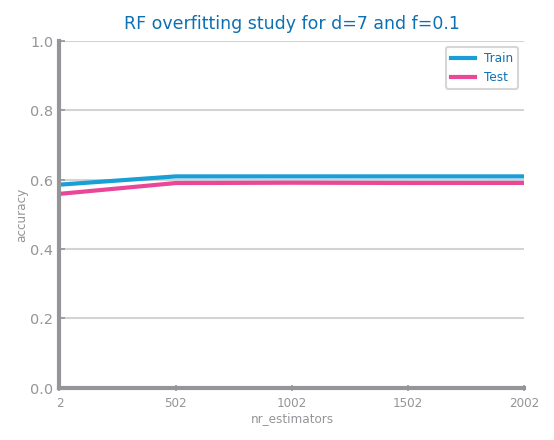

In [9]:
d_max: int = best_params["params"][0]
feat: float = best_params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "accuracy"

for n in nr_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

plt.figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"RF overfitting study for d={d_max} and f={feat}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
plt.savefig(f"images/{file_tag}_{eval_metric}_overfitting.png")